In [2]:
pip install seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

# 🔹 Cargar los datos
df_btc = pd.read_csv("Database/btc_final.csv")

# 🔹 Convertir fechas a datetime
df_btc['Date'] = pd.to_datetime(df_btc['Date'])

# 🔹 Imputación de valores faltantes
tech_indicators = ['BTC_EMA_20', 'BTC_RSI', 'BTC_MACD']  # Eliminamos BTC_SMA_50

# Obtener los primeros dos meses de datos
start_date = df_btc['Date'].min()
end_date = start_date + pd.DateOffset(months=2)
df_initial = df_btc[(df_btc['Date'] >= start_date) & (df_btc['Date'] < end_date)]

# Rellenar indicadores técnicos con el promedio de los primeros dos meses
for col in tech_indicators:
    mean_value = df_initial[col].mean()
    df_btc.loc[:, col] = df_btc[col].fillna(mean_value)

# Rellenar Fear_Greed_Index con el promedio entre el valor anterior y el siguiente
df_btc.loc[:, 'Fear_Greed_Index'] = df_btc['Fear_Greed_Index'].interpolate(method='linear')

# 🔹 Eliminar variables redundantes
#df_btc.drop(columns=['BTC_SMA_50', 'BTC_Price_CryptoCompare', 'Open', 'High', 'Low'], inplace=True, errors='ignore')

# 🔹 Eliminar variables redundantes
df_btc.drop(columns=['BTC_SMA_50', 'Volume','BTC_Price_CryptoCompare', 'Open', 'High', 'Low', 'BTC_Trends'], inplace=True, errors='ignore') # 'BTC_Sentiment'

# 🔹 Normalizar los datos
scaler = MinMaxScaler()
df_scaled = df_btc.copy()
df_scaled[df_btc.columns.difference(['Date'])] = scaler.fit_transform(df_btc[df_btc.columns.difference(['Date'])])

# 🔹 Mover la columna "Close" al final
df_scaled = df_scaled[[col for col in df_scaled.columns if col != "Close"] + ["Close"]]
# 🔹 Eliminar la columna de fechas antes de guardar
df_scaled = df_scaled.drop(columns=['Date'], errors='ignore')

# 🔹 Guardar datasets preprocesados
np.save("Dataset/df_scaled_btc.npy", df_scaled.values)
print("✅ Datos preprocesados guardados en Dataset/")

2025-03-16 20:29:27.959943: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


✅ Datos preprocesados guardados en Dataset/


#### Crear secuencias de tiempo (Seleccion aleatorea)

In [2]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

# 🔹 Cargar los datos normalizados
df_scaled = np.load("Dataset/df_scaled_btc.npy", allow_pickle=True)

# 🔹 Crear secuencias para LSTM
sequence_length = 60  # 60 días de ventana
def create_sequences(data, target_index, sequence_length):
    sequences, targets = [], []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i : i + sequence_length, :-1])  # Features
        targets.append(data[i + sequence_length, target_index])  # Target
    return np.array(sequences), np.array(targets)

# Definir la posición de la variable objetivo (última columna en df_scaled)
target_index = -1  # Última columna (precio futuro)

X, Y = create_sequences(df_scaled, target_index, sequence_length)

# 🔹 Dividir en Train/Test
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = Y[:train_size], Y[train_size:]

# 🔹 Guardar datasets para evitar desorden
np.save("Dataset/X_train_btc.npy", X_train)
np.save("Dataset/X_test_btc.npy", X_test)
np.save("Dataset/y_train_btc.npy", y_train)
np.save("Dataset/y_test_btc.npy", y_test)
print("✅ Datasets para LSTM guardados en Dataset/")

✅ Datasets para LSTM guardados en Dataset/


#### definir y entrenar el modelo Bi-LSTM

Epoch 1/100


/opt/conda/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 15s 152ms/step - loss: 3.2263 - val_loss: 2.1023
Epoch 2/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 9s 132ms/step - loss: 1.8150 - val_loss: 1.1496
Epoch 3/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 13s 183ms/step - loss: 0.9883 - val_loss: 0.6163
Epoch 4/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 9s 166ms/step - loss: 0.5216 - val_loss: 0.3152
Epoch 5/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 10s 164ms/step - loss: 0.2662 - val_loss: 0.1634
Epoch 6/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 8s 182ms/step - loss: 0.1323 - val_loss: 0.0784
Epoch 7/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 10s 179ms/step - loss: 0.0649 - val_loss: 0.0527
Epoch 8/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 7s 155ms/step - loss: 0.0321 - val_loss: 0.0292
Epoch 9/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 12s 192ms/step - loss: 0.0166 - val_loss: 0.0220
Epoch 10/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 9s 170ms/step - loss: 0.0099 - val_loss: 0.0177
Epoch 11/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 8s 180ms/step - loss: 0.0064 - val_loss: 0.0182
Epoch 12/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 10s 182m

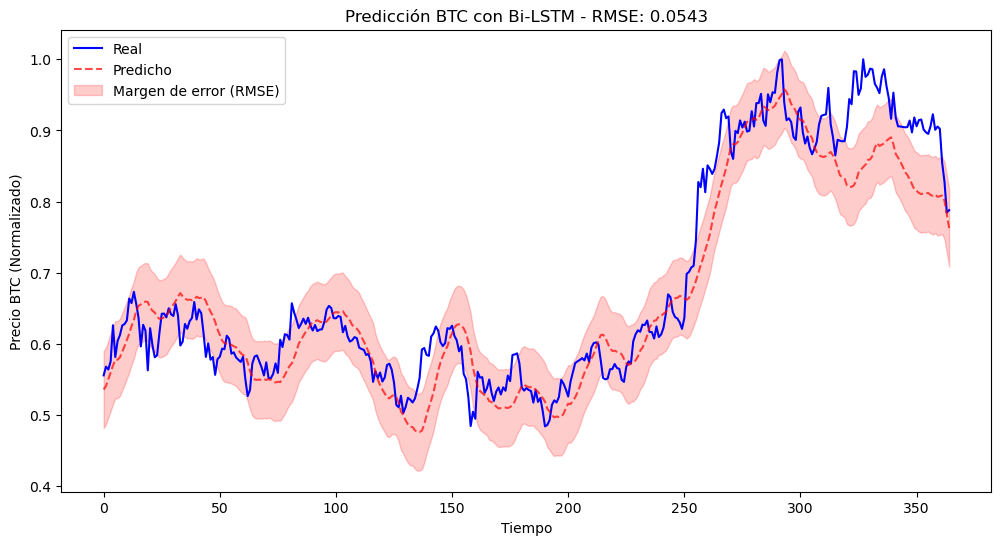

In [5]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Bidirectional, Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
import numpy as np
import matplotlib.pyplot as plt

# 🔹 Cargar datasets preprocesados
X_train = np.load("Dataset/X_train_btc.npy")
X_test = np.load("Dataset/X_test_btc.npy")
y_train = np.load("Dataset/y_train_btc.npy")
y_test = np.load("Dataset/y_test_btc.npy")

# 🔹 Construcción del modelo Bi-LSTM optimizado
model_btc = Sequential([
    Bidirectional(LSTM(64, return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(0.01), activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2]))),
    Dropout(0.3),
    Bidirectional(LSTM(64, return_sequences=False, kernel_regularizer=tf.keras.regularizers.l2(0.01), activation='tanh')),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1, activation='linear')
])

# 🔹 Compilar modelo
model_btc.compile(optimizer=Adam(learning_rate=0.0005), loss='mse')

# 🔹 Early Stopping con más paciencia para mejorar estabilidad
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# 🔹 Entrenar el modelo
history = model_btc.fit(
    X_train, y_train,
    epochs=100,  # Probamos con más épocas para aprovechar Early Stopping
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping]
)

# 🔹 Evaluación del modelo
loss = model_btc.evaluate(X_test, y_test)
rmse = np.sqrt(loss)
print(f"📉 RMSE del modelo: {rmse:.4f}")

# 🔹 Obtener la desviación real del precio de BTC en el dataset
btc_price_std = np.std(y_train) * 50000  # Ajustamos escala para convertirlo a USD
rmse_dollars = rmse * btc_price_std
print(f"💰 RMSE en dólares: ${rmse_dollars:.2f}")

# 🔹 Predicciones
y_pred = model_btc.predict(X_test)

# 🔹 Gráfica mejorada de predicción vs. valores reales
plt.figure(figsize=(12, 6))
plt.plot(y_test, label="Real", color='blue')
plt.plot(y_pred, label="Predicho", linestyle="dashed", color='red', alpha=0.7)
plt.fill_between(range(len(y_test)), y_pred.flatten() - rmse, y_pred.flatten() + rmse, color='red', alpha=0.2, label="Margen de error (RMSE)")
plt.xlabel("Tiempo")
plt.ylabel("Precio BTC (Normalizado)")
plt.legend()
plt.title(f"Predicción BTC con Bi-LSTM - RMSE: {rmse:.4f}")
plt.show()

In [6]:
# Guardar el modelo entrenado
model_btc.save("model_btc_Bi_LSTM.keras")
print("✅ Modelo LSTM guardado en model_btc_Bi_LSTM.keras")

✅ Modelo LSTM guardado en model_btc_Bi_LSTM.keras


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step 


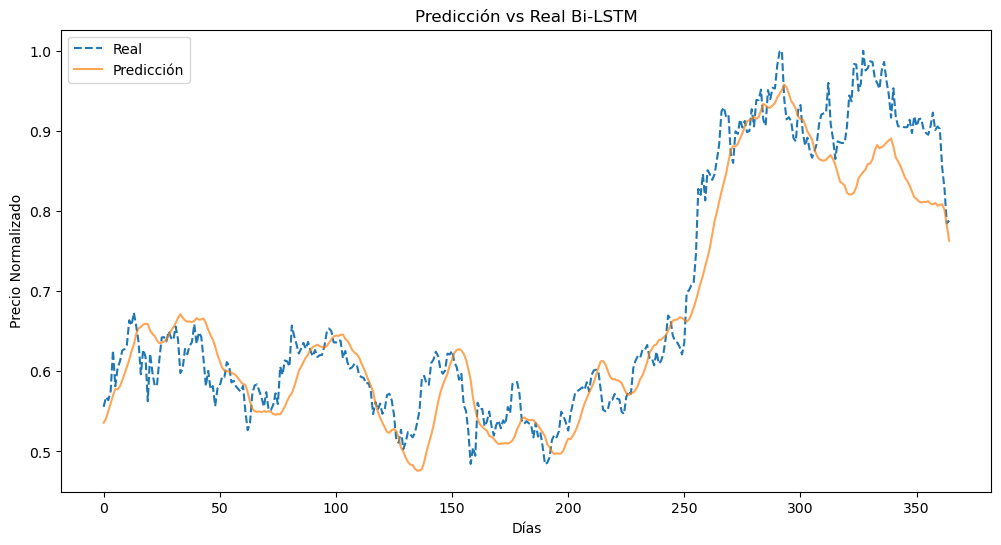

💰 RMSE en dólares: $339.68
📉 Error Cuadrático Medio (MSE): 0.002468587566854753
📉 Raíz del Error Cuadrático Medio (RMSE): 0.049684882679289416


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import load_model

# 🔹 Cargar los datasets para evaluar el modelo
X_test = np.load("Dataset/X_test_btc.npy", allow_pickle=True)
y_test = np.load("Dataset/y_test_btc.npy", allow_pickle=True)

# 🔹 Cargar el modelo entrenado
model = load_model("model_btc_Bi_LSTM.keras")

# 🔹 Hacer predicciones
y_pred = model.predict(X_test)

# 🔹 Desescalar los valores predichos y reales
y_test = y_test.reshape(-1, 1)
y_pred = y_pred.reshape(-1, 1)

# 🔹 Visualizar las predicciones
plt.figure(figsize=(12, 6))
plt.plot(y_test, label="Real", linestyle='dashed')
plt.plot(y_pred, label="Predicción", alpha=0.7)
plt.legend()
plt.title("Predicción vs Real Bi-LSTM")
plt.xlabel("Días")
plt.ylabel("Precio Normalizado")
plt.show()

# 🔹 Evaluar el modelo
mse = np.mean((y_pred - y_test) ** 2)
rmse = np.sqrt(mse)

# 🔹 Obtener la desviación real del precio de BTC en el dataset
btc_price_std = np.std(y_pred) * 50000  # Ajustamos escala para convertirlo a USD
rmse_dollars = rmse * btc_price_std
print(f"💰 RMSE en dólares: ${rmse_dollars:.2f}")
print(f"📉 Error Cuadrático Medio (MSE): {mse}")
print(f"📉 Raíz del Error Cuadrático Medio (RMSE): {rmse}")